## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pathlib import Path
import math
from matplotlib import gridspec

## Load dataset

In [2]:
path = Path().cwd()

clases_file = path.parent / "Data" / "ziplabel.csv"
cls = pd.read_csv(clases_file, header=None)

data_file = path.parent / "Data" / "zipdata.csv"
X = np.asarray(pd.read_csv(data_file, header=None))

[N, p] = X.shape

minX = list(np.min(X, axis=0)) # data range min
maxX = list(np.max(X, axis=0)) # data range max

### 3 Use the gap-statistic to select K for K-means clustering on the zip data.
> You will need to write the calculations of the within-class dissimilarities and the gap statistic yourself.

In [45]:
def within_class(X, cluster_centers, labels):
    all_labels = np.unique(labels)
    
    w = 0
    for i, l in enumerate(all_labels):
        indices = labels == l
        cur_x = X[indices]
        # print((cur_x - cluster_centers[i]).shape)
        
        w += 1/2 * np.sum(np.linalg.norm(cur_x - cluster_centers[i], ord=2, axis=0)**2)
    return w

In [44]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
print(within_class(X, centroids, labels))

print(centroids.shape)

20019.68127347632
(3, 256)


In [4]:
X.shape

(400, 256)

In [46]:
seed = 42
clustersNr = 10
list_of_clusters = list(range(1,clustersNr+1))
Nsim = 20
W = np.zeros(clustersNr)
Wu = np.zeros((clustersNr, Nsim))
for nrClusters in list_of_clusters: # Want actual number included
    # kmeans first
    kmeans = KMeans(n_clusters=nrClusters, random_state=seed)
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    # Then Compute within-class dissimilarity W given X (the data), C (the cluster centers)
    # and labelCluster (the predicted cluster numbers)
    W[nrClusters-1] = within_class(X, centroids, labels)
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        
        # perform K-means on the simulated data
        sim_km = KMeans(n_clusters=nrClusters, random_state=seed)
        sim_labels = sim_km.fit_predict(Xu)
        sim_centroids = sim_km.cluster_centers_
        
        # Compute within-class dissmiliarity for the simulated data Wu given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and labelClusterU (the predicted cluster numbers)
        # for the simulated data).
        Wu[nrClusters-1, j] = within_class(Xu, sim_centroids, sim_labels)
        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

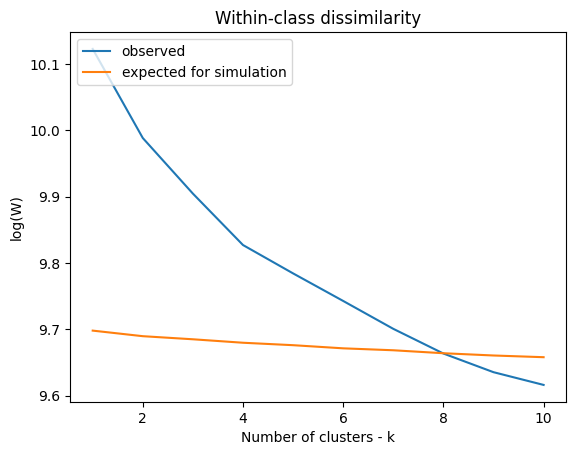

In [47]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

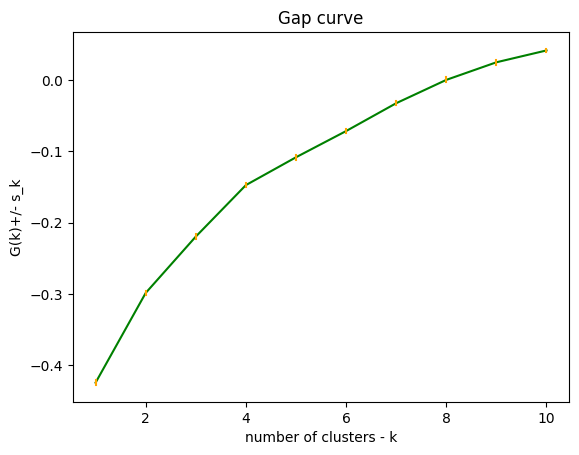

In [48]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

In [49]:
# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = clustersNr
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_of_clusters[K_opt[0]])

Gap-statistic, optimal K = 10


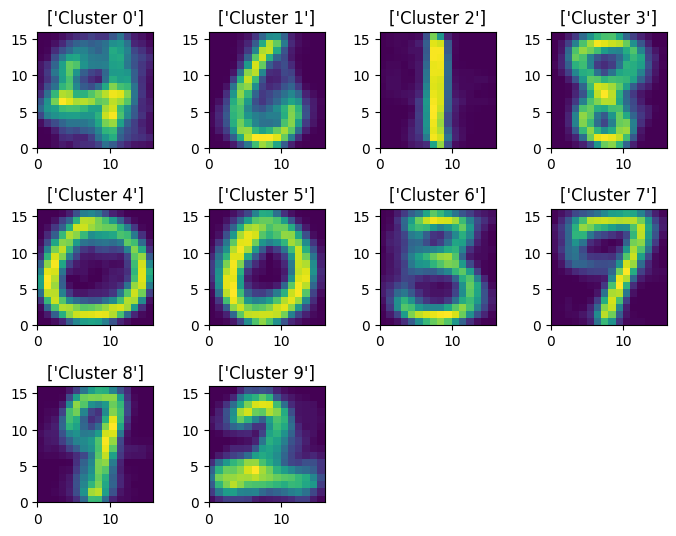

In [50]:
if K_opt > 16:
    k = 16
else:
    k = K_opt

kMeansOpt = KMeans(n_clusters=k, random_state=0).fit(X)
C = kMeansOpt.cluster_centers_ # the cluster means
resp = kMeansOpt.labels_ # a vector of the cluster number for each observation

gs = gridspec.GridSpec(4, 4)
fig = plt.figure(figsize=(7,7))
for i in range(len(C)):
    ax = fig.add_subplot(gs[i])
    c=C[i].reshape(16,16)
    c=np.flipud(c)
    ax.pcolor(c)
    ax.set_title(['Cluster %d' %i])
    ax.set_aspect('equal', adjustable='box')

fig.tight_layout()
plt.show()